# **LAB-8**
# Name =G.KAVYASRI
# Roll =CS20B1126

# Implantation of CNN using PyTorch Tutorial for Image classification.
1. Load and normalize any dataset available in PyTorch
2. Design LeNet model using PyTorch.
3. Train and Test the model on the selected dataset
4. Experiment with different number of filters, kernel sizes, number of layers.
5. Compare the results.

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from time import time

import numpy as np
import pandas as pd

In [29]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# **Data Collection**

In [30]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [31]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

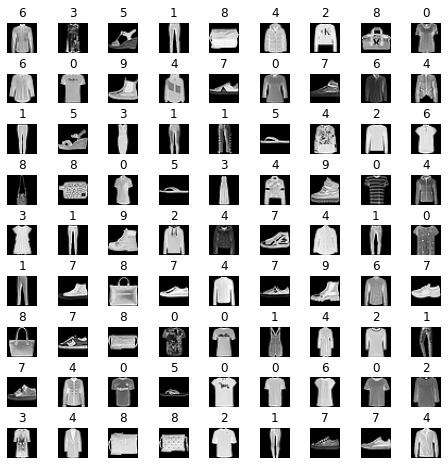

In [32]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 9,9
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.subplots_adjust(hspace=0.7)
plt.show()

In [33]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [34]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

In [35]:
def __len__(self):
    return len(self.img_labels)

In [36]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

# **DataLoaders**


In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


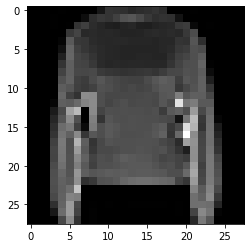

Label: 2


In [38]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# **LeNet model using pytorch**

**Define the Network**

In [39]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
  # class torch.nn.Conv2d(in_channels,out_channels,kernel_size,
  # stride=1,padding=0,dilation=1,groups=1,bias=True)
		self.conv1 = nn.Conv2d(1, 15, kernel_size=5)
		self.conv2 = nn.Conv2d(15, 30, kernel_size=5)
  #self.pool=nn.MaxPool2d(2,2)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(30*4*4, 50)
		self.fc2 = nn.Linear(50, 15)
	
	def forward(self, x):
  #  class torch.nn.MaxPool2d(kernel_size,stride=None,
  #  padding=0,dilation=1,return_indices=False,cell_mode=False)
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
  # x = self.pool(F.relu(self.conv2(x)))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1,30*4*4)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x

net = Net()

**Define Loss and Optimizer**

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.8)


# **Training and testing**


In [41]:
from torch.autograd import Variable

def train_model(epochs, model):
	t0 = time()
	for epoch in range(epochs):
		running_loss = 0.0
		correct = 0
		total = 0
		for i, data in enumerate(train_dataloader, 0):
			inputs, labels = data

			inputs, labels = Variable(inputs), Variable(labels)
   
			optimizer.zero_grad()
   
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()
   
			if (i % 200) == 199: # for every 200 mini batches print
					
					print(f"Epoch: {epoch + 1}/{epochs}, Batch Number: {i + 1} => Loss: {round(running_loss / 200,4)}, Accuracy: {round(100.*(correct/total), 4)}")
					running_loss = 0.0
	print("Finished Training in %.3fs"%(time()- t0))




In [42]:
def test_model(model):
	correct = 0
	total = 0
	with torch.no_grad():
			for data in test_dataloader:
					images, labels = data
					outputs = model(images)
					_, predicted = torch.max(outputs.data, 1)
					total += labels.size(0)
					correct += (predicted == labels).sum().item()

	print(f'Accuracy % of test images is: {100 * correct // total}')

In [43]:


train_model(epochs=3, model=net)
test_model(model=net)



Epoch: 1/3, Batch Number: 200 => Loss: 1.796, Accuracy: 36.2656
Epoch: 1/3, Batch Number: 400 => Loss: 0.9289, Accuracy: 50.9062
Epoch: 1/3, Batch Number: 600 => Loss: 0.7943, Accuracy: 57.3021
Epoch: 1/3, Batch Number: 800 => Loss: 0.7345, Accuracy: 61.0098
Epoch: 2/3, Batch Number: 200 => Loss: 0.6613, Accuracy: 75.7266
Epoch: 2/3, Batch Number: 400 => Loss: 0.6252, Accuracy: 76.1445
Epoch: 2/3, Batch Number: 600 => Loss: 0.5903, Accuracy: 76.9089
Epoch: 2/3, Batch Number: 800 => Loss: 0.5702, Accuracy: 77.4648
Epoch: 3/3, Batch Number: 200 => Loss: 0.5482, Accuracy: 79.8047
Epoch: 3/3, Batch Number: 400 => Loss: 0.5265, Accuracy: 80.1758
Epoch: 3/3, Batch Number: 600 => Loss: 0.5272, Accuracy: 80.5391
Epoch: 3/3, Batch Number: 800 => Loss: 0.481, Accuracy: 81.0371
Finished Training in 92.924s
Accuracy % of test images is: 81


# **Experiment with different number of filters, kernel sizes, number of layers.**

In [44]:
class Net2(nn.Module):
	def __init__(self):
		super(Net2, self).__init__()
		self.conv1 = nn.Conv2d(1, 15, kernel_size=7)
		self.conv2 = nn.Conv2d(15, 35, kernel_size=7)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(35*2*2, 150)
		self.fc2 = nn.Linear(150, 50)
		self.fc3 = nn.Linear(50, 35)
	
	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 35*2*2)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		x = F.elu(self.fc3(x))
		return x

net_2 = Net2()


In [57]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.01)


In [46]:
train_model(epochs=2, model=net_2)
test_model(model=net_2)

Epoch: 1/2, Batch Number: 200 => Loss: 1.1701, Accuracy: 57.2344
Epoch: 1/2, Batch Number: 400 => Loss: 0.7481, Accuracy: 64.8477
Epoch: 1/2, Batch Number: 600 => Loss: 0.7079, Accuracy: 68.0599
Epoch: 1/2, Batch Number: 800 => Loss: 0.6639, Accuracy: 70.0723
Epoch: 2/2, Batch Number: 200 => Loss: 0.6215, Accuracy: 77.3828
Epoch: 2/2, Batch Number: 400 => Loss: 0.6188, Accuracy: 77.4258
Epoch: 2/2, Batch Number: 600 => Loss: 0.641, Accuracy: 77.3828
Epoch: 2/2, Batch Number: 800 => Loss: 0.5894, Accuracy: 77.6992
Finished Training in 66.865s
Accuracy % of test images is: 76


In [67]:
class Net3(nn.Module):
	def __init__(self):
		super(Net3, self).__init__()
		self.conv1 = nn.Conv2d(1, 15, kernel_size=7)
		self.conv2 = nn.Conv2d(15, 30, kernel_size=7)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(30*2*2, 150)
		self.fc2 = nn.Linear(150, 50)
		self.fc3 = nn.Linear(50, 30)
	
	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 30*2*2)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		x = F.elu(self.fc3(x))
		return x

net_3 = Net3()

In [68]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_3.parameters(), lr=0.01)

In [69]:
train_model(epochs=2, model=net_3)
test_model(model=net_3)

Epoch: 1/2, Batch Number: 200 => Loss: 1.125, Accuracy: 57.7344
Epoch: 1/2, Batch Number: 400 => Loss: 0.7364, Accuracy: 65.4336
Epoch: 1/2, Batch Number: 600 => Loss: 0.7039, Accuracy: 68.3385
Epoch: 1/2, Batch Number: 800 => Loss: 0.6649, Accuracy: 70.2227
Epoch: 2/2, Batch Number: 200 => Loss: 0.6497, Accuracy: 76.6172
Epoch: 2/2, Batch Number: 400 => Loss: 0.652, Accuracy: 76.3945
Epoch: 2/2, Batch Number: 600 => Loss: 0.6278, Accuracy: 76.6849
Epoch: 2/2, Batch Number: 800 => Loss: 0.6035, Accuracy: 77.0801
Finished Training in 68.568s
Accuracy % of test images is: 73


**By changing kernel size and in_channels,out_channels the accuracy changes.**


# **Compare the Results**

In [70]:
classes=('label-0','label-1','label-2','label-3','label-4','label-5',
'label-6','label-7','label-8','label-9')
#classes = ('t-shirts','pants', 'shirts', 'dresses', 'coats',
#          'slippers', 'tops', 'shoes', 'handbags', 'highheels')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: label-0 is 74.5 %
Accuracy for class: label-1 is 96.5 %
Accuracy for class: label-2 is 68.7 %
Accuracy for class: label-3 is 82.1 %
Accuracy for class: label-4 is 86.4 %
Accuracy for class: label-5 is 95.3 %
Accuracy for class: label-6 is 41.7 %
Accuracy for class: label-7 is 86.7 %
Accuracy for class: label-8 is 94.6 %
Accuracy for class: label-9 is 93.4 %
